# In Depth: Gaussian Mixture Models

The k-means clustering model explored in the previous section is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application. In particular, the non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations. In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind k-means, but can also be a powerful tool for estimation beyond simple clustering.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Motivating GMM: Weaknesses of k-Means

Let's take a look at some of the weaknesses of k-means and think about how we might improve the cluster model. As we saw in the previous section, given simple, well-seperated data, k-means finds suitable clustering results.

For example, if we have simple blobs of data, the k-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

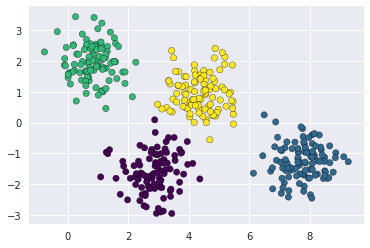

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels =  kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, 
            s=40, cmap='viridis', edgecolors='black');

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, edgecolor='black')
    
    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

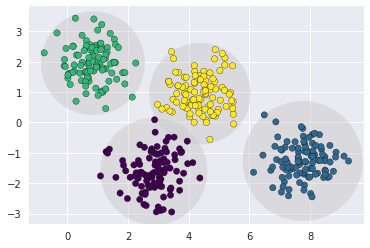

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

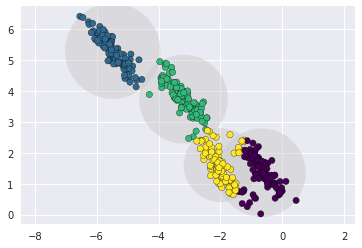

In [6]:
rng =  np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

# Generalizing E-M: Gaussian Mixture Models

A GMM attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

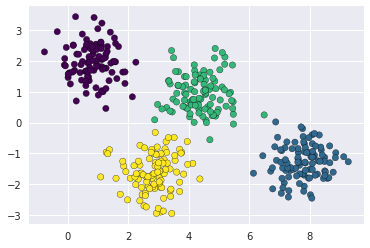

In [7]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', edgecolors='black');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments-in Scikit-Learn this is done using the `predict_proba` method. This returns a matrix of size `[n_samples, n_clusters]` which measures the probability that any point belongs to the given cluster:

In [8]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.463 0.537 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

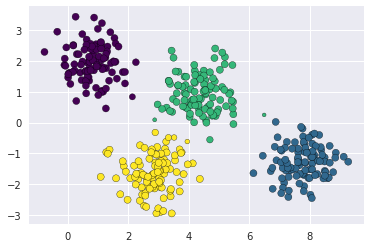

In [9]:
size = 50 * probs.max(1) ** 2 
plt.scatter(X[:, 0], X[:, 1], c=labels,
            cmap='viridis', s=size, edgecolor='black');

Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation-maximization approach which qualitatively does the following:
1. Choose starting guesses for the location and shape
2. Repeat until converged:
    1. E-step: for each point, find weights encoding the probability of membership in each cluster
    2. M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

## How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset. A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid over-fitting. Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Scikit-Learn's GMM estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

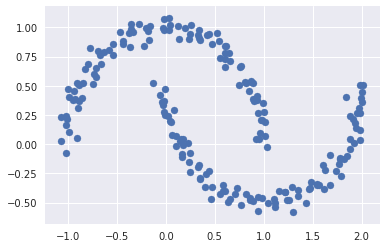

In [17]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

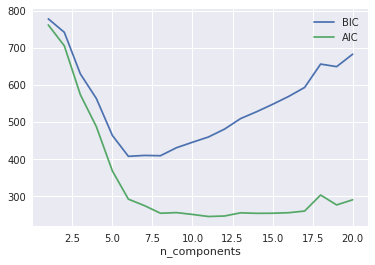

In [18]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice. As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works as a density estimator, not how well it works as a clustering algorithm.

# Example: GMM for Generating New Data

We just saw a simple example of using GMM as a generative model of data in order to create new samples from the distribution defined by the input data. Here we will run with this idea and generate new handwritten digits from the standard digits corpus that we have used before.

In [19]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

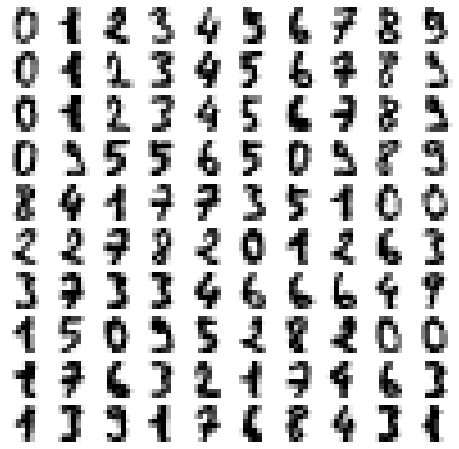

In [33]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more. GMMs can have difficulty converging in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data. Here we will use a straightforward PCA, asking it to preserve 99% of the variance in the projected data:

In [34]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss. Given this projected data, let's use the AIC to get a gauge for the number of GMM components we should use:

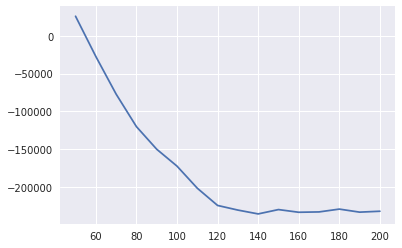

In [39]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It appears that around 140 components minimizes the AIC.

In [62]:
gmm = GMM(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

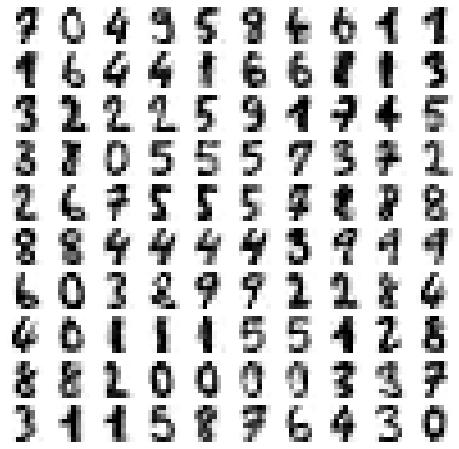

In [63]:
data_new = gmm.sample(100)
data_new[0].shape

digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)



The results for the most part look like plausible digits from the dataset!

Consider what we've done here: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits" which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model. Such a generative model of digits can prove very useful as a component of a Bayesian generative classifier.